In [111]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from matplotlib.lines import Line2D

from cryptic_rnn import *

In [127]:
def run_exp(trainseqs_old, trainseqs_old_p, testseqs_old1, testseqs_old2, cue_dict, num_inputs):
    """ assigns integers to symbols and trains RNN on sequence - evaluating on test set on each trial"""
    # assigning value to symbol and calculating trial outputs
    all_syms = list(cue_dict.keys())
    all_input_vals = list(np.arange(2,18))
    input_vals = random.sample(all_input_vals,num_inputs)
    input_vals.sort() # sort values (so A is smallest)
    # randomly select values for each input
    for i, s in enumerate(all_syms):
        cue_dict[s] = input_vals[i]
    
    # load train and test trials
    trainseqs = change_dict(trainseqs_old, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

    trainseqs = change_dict(trainseqs_old_p, cue_dict)
    train_inputs = convert_seq2inputs(trainseqs, num_classes=num_classes, seq_len=5)
    trainset_p = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old1, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset1 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)
    
    testseqs = change_dict(testseqs_old2, cue_dict)
    test_inputs = convert_seq2inputs(testseqs, num_classes=num_classes, seq_len=5)
    testset2 = DataLoader(test_inputs, batch_size=batchsize, shuffle=True)

    # run primitive training RNN
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers, xavier_gain)
    model_p = copy.deepcopy(model)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset, [trainset, testset1, testset2], epochs, hidden_size)
    
    optimizer = torch.optim.Adam(model_p.parameters(), lr=learningRate)
    loss2, acc2 = run_acc(model_p,optimizer,criterion, trainset_p, [trainset_p, testset1, testset2], epochs, hidden_size)
       
    return {'cue_dict':cue_dict, 'loss':loss1, 'acc':acc1, 'mod': model, 'test1': testset1,'test2': testset2,
           'loss_p':loss2, 'acc_p':acc2, 'mod_p': model_p}

def collect_accs(trainseqs, trainseqs_p, testseqs1, testseqs2, cue_dict, num_inputs):
    """ trains RNNs in parallel and collects r^2 and acc vals"""
    t1 = time.time()
    res  = Parallel(n_jobs = -1)(delayed(run_exp)(trainseqs, trainseqs_p, testseqs1, testseqs2, cue_dict, num_inputs) for i in range(num_sims))
    t2 = time.time()
    print('run time: ', (t2-t1)/60)

    tests1 = [r['test1'] for r in res]
    tests2 = [r['test2'] for r in res]
    cue_dicts = [r['cue_dict'] for r in res]
    
    mods = [r['mod'] for r in res]
    loss_list = [r['loss'] for r in res]
    acc_train_list = [r['acc'][:,0] for r in res]
    acc_test_list1 = [r['acc'][:,1] for r in res]
    acc_test_list2 = [r['acc'][:,2] for r in res]
    acc_train = np.array(acc_train_list).T
    acc_test1 = np.array(acc_test_list1).T
    acc_test2 = np.array(acc_test_list2).T


    mods_p = [r['mod_p'] for r in res]
    loss_list_p = [r['loss_p'] for r in res]
    acc_train_list_p = [r['acc_p'][:,0] for r in res]
    acc_test_list1_p = [r['acc_p'][:,1] for r in res]
    acc_test_list2_p = [r['acc_p'][:,2] for r in res]
    acc_train_p = np.array(acc_train_list_p).T
    acc_test1_p = np.array(acc_test_list1_p).T
    acc_test2_p = np.array(acc_test_list2_p).T
    
       
    acc_df = pd.DataFrame({'acc_train': acc_train[-1,:], 'acc_train_p': acc_train_p[-1,:],\
                          'acc_test1': acc_test1[-1,:], 'acc_test1_p': acc_test1_p[-1,:],
                          'acc_test2': acc_test2[-1,:], 'acc_test2_p': acc_test2_p[-1,:]})
    
    # fully trained
    fully_trained = acc_df[(acc_df['acc_train'] == 1)&(acc_df['acc_train_p'] == 1)]
    fully_trained_idx = fully_trained.index
    ft_mods = [mods[i] for i in fully_trained_idx]
    print('fully trained models: ',len(ft_mods))
    
    if len(ft_mods) > 0:
        
        ft_tests1 = [tests1[i] for i in fully_trained_idx]
        ft_tests2 = [tests2[i] for i in fully_trained_idx]
        ft_mods_p = [mods_p[i] for i in fully_trained_idx]
        
        ft_loss = np.hstack([loss_list[i] for i in fully_trained_idx])
        ft_train_loss = np.array([acc_train_list[i] for i in fully_trained_idx]).T
        ft_train_acc = np.array([acc_train_list[i] for i in fully_trained_idx]).T
        ft_tests_acc1 = np.array([acc_test_list1[i] for i in fully_trained_idx]).T
        ft_tests_acc2 = np.array([acc_test_list2[i] for i in fully_trained_idx]).T
        final_acc = np.mean(ft_tests_acc2[-1,:])
        final_acc_std = np.std(ft_tests_acc2[-1,:])
    
        ft_loss_p = np.hstack([loss_list_p[i] for i in fully_trained_idx])
        ft_train_acc_p = np.array([acc_train_list_p[i] for i in fully_trained_idx]).T
        ft_tests_acc1_p = np.array([acc_test_list1_p[i] for i in fully_trained_idx]).T
        ft_tests_acc2_p = np.array([acc_test_list2_p[i] for i in fully_trained_idx]).T
        final_acc_p = np.mean(ft_tests_acc2_p[-1,:])
        final_acc_std_p = np.std(ft_tests_acc2_p[-1,:])
        
        plt.figure()
        r2, dfs, alldfs = predcorr(ft_mods, ft_tests2, hidden_size, plot_corr = True)
        plt.title('no prims')
        plt.figure()
        r2_p, dfs_p, alldfs = predcorr(ft_mods_p, ft_tests2, hidden_size, plot_corr =True)
        plt.title('with prims')
        
        plotNNs([ft_loss], [ft_train_acc, ft_tests_acc1, ft_tests_acc2], \
            ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = 'no prims', shift = 0)

        plotNNs([ft_loss], [ft_train_acc_p, ft_tests_acc1_p,ft_tests_acc2_p ], \
            ['train', 'test1', 'test2'], colors = ['green', 'orange', 'red'], title = 'with prims', shift = 0)
        
        
        print('no prims R^2: ', r2, '; acc = ', final_acc)
        print('with prims R^2: ', r2_p, '; acc = ', final_acc_p)
        
    else:
        r2, dfs, final_acc = 0, 0, 0
        r2_p, dfs_p, final_acc_p = 0, 0, 0
        
    return {'res':res, 'mods':mods, 'mods_p':mods_p, 'tests1': tests1,'tests2': tests2, 'cue_dicts': cue_dicts, 'acc_df':acc_df,\
           'dfs':dfs, 'dfs_p':dfs_p, 'r2':r2, 'r2_p':r2_p, 'final_acc':final_acc, 'final_acc_p': final_acc_p,\
           'final_acc_std':final_acc, 'final_acc_std_p': final_acc_p}


def generate_pos_trials(op, input_ids, init_values, cue_dict, steps = 1):
    
    ''' function for generating all permutations of 1 step trials '''
    
    seq = []
    combi_inputcue = list(itertools.product(input_ids, repeat= steps))
    combi_ops = list(itertools.product(ops, repeat= steps))
    for init in input_ids:
        for cue in combi_inputcue:
            seq.append([('+',init),
                        *zip(combi_ops[0], cue), '=']) #group per time point t
    for s in seq:
        s.append(calculate_output(s, cue_dict))
    return seq

def MDS_plot(matlist, title = ''):
    
    testseqs = generate_pos_trials(ops, all_syms, all_syms, cue_dict, steps = 2)
        
    colors1 = ['green']*16 + ['blue']*16 + ['orange']*16 + [ 'red']*16
    colors2 = (['green']*4 + ['blue']*4 + ['orange']*4 + ['red']*4)*4
    colors3 = ['green','blue', 'orange','red']*16
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=4, label='A _ _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=4, label='B _ _'), 
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=4, label='C _ _'),
                       Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=4, label='D _ _ '),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=8, label= ' _ A _'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=8, label=' _ B _'), 
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=8, label=' _ C _'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize= 8, label=' _ D _'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=12, label=' _ _ A'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=12, label=' _ _ B'), 
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=12, label=' _ _ C'),
                       Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=12, label=' _ _ D')]
    
    plt.rcParams['figure.figsize'] = 6, 6
    fig, axs = plt.subplots(2,2)

    for j, dist in enumerate(matlist[1:]):
        mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
        X_transform = mds.fit_transform(dist)
        ax = axs[math.floor(j/2), j%2]
        ax.title.set_text('step: '+str(j))
        for i in range(len(testseqs)):
            ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i])
            ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i])
            ax.scatter(X_transform[i,0], X_transform[i,1], s=250, facecolors='none', edgecolors=colors3[i])

    plt.suptitle('2D-MDS'+title)
    fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5)) 


In [103]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
num_sims = 8
epochs = 1000
# 
xavier_gain = 0.001

In [104]:
ops = '+'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)

pos_primitives = generate_pos_primitives(all_syms, cue_dict)
print(pos_primitives)

{'A': 8, 'B': 10, 'C': 17, 'D': 7}
[[('+', 'A'), '=', 8], [('+', 'B'), '=', 10], [('+', 'C'), '=', 17], [('+', 'D'), '=', 7]]


In [ ]:
# generalisation to 2 step

train:  [[('+', 'A'), ('+', 'B'), '=', 18], [('+', 'B'), ('+', 'C'), '=', 27], [('+', 'C'), ('+', 'D'), '=', 24], [('+', 'D'), ('+', 'A'), '=', 15], [('+', 'B'), ('+', 'C'), '=', 27], [('+', 'D'), ('+', 'A'), '=', 15]]
test 1:  [[('+', 'A'), ('+', 'A'), '=', 16], [('+', 'A'), ('+', 'C'), '=', 25], [('+', 'A'), ('+', 'D'), '=', 15], [('+', 'B'), ('+', 'A'), '=', 18], [('+', 'B'), ('+', 'B'), '=', 20], [('+', 'B'), ('+', 'D'), '=', 17], [('+', 'C'), ('+', 'A'), '=', 25], [('+', 'C'), ('+', 'B'), '=', 27], [('+', 'C'), ('+', 'C'), '=', 34], [('+', 'D'), ('+', 'B'), '=', 17], [('+', 'D'), ('+', 'C'), '=', 24], [('+', 'D'), ('+', 'D'), '=', 14]]
test 2:  [[('+', 'D'), ('+', 'A'), ('+', 'D'), '=', 22], [('+', 'A'), ('+', 'D'), ('+', 'D'), '=', 22], [('+', 'A'), ('+', 'D'), ('+', 'A'), '=', 23], [('+', 'A'), ('+', 'C'), ('+', 'A'), '=', 33], [('+', 'A'), ('+', 'B'), ('+', 'C'), '=', 35], [('+', 'C'), ('+', 'C'), ('+', 'D'), '=', 41], [('+', 'B'), ('+', 'C'), ('+', 'D'), '=', 34], [('+', 'C'),

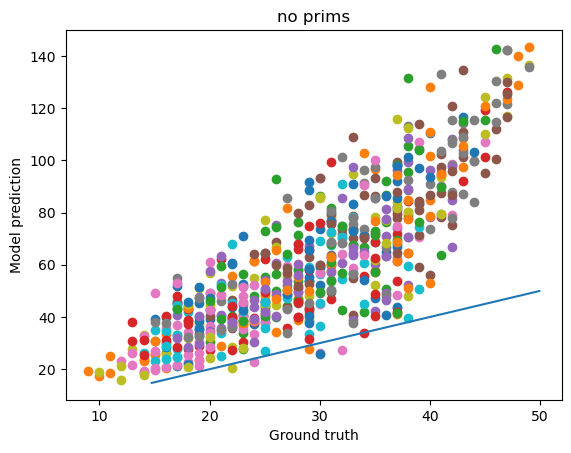

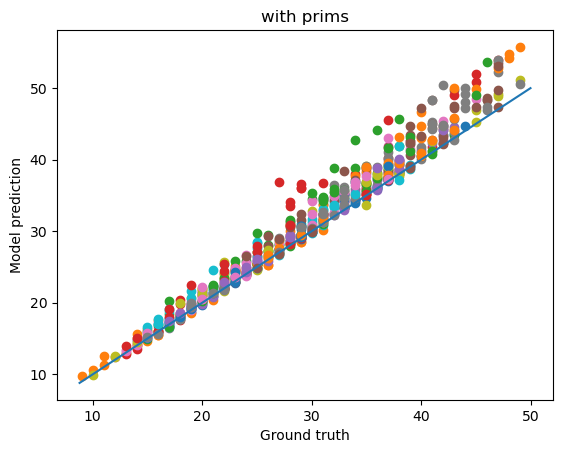

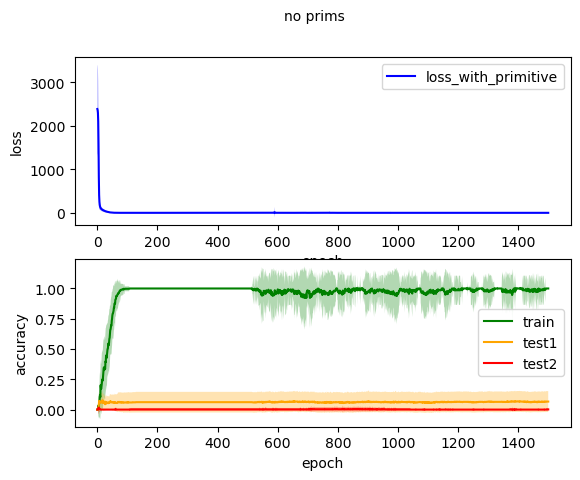

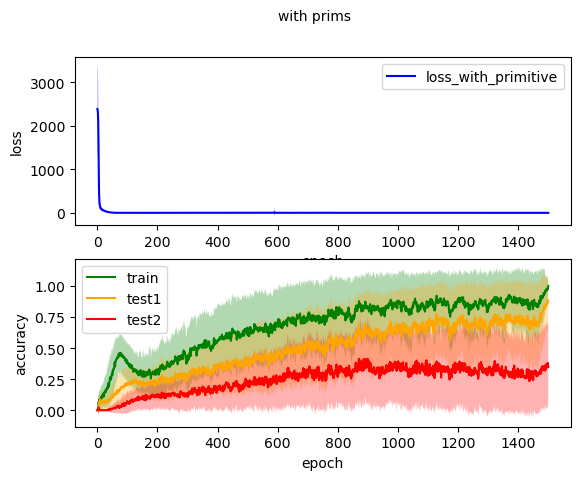

In [105]:
num_sims = 104
epochs = 1500

trainseqs = generate_pos_other(ops, all_syms, cue_dict) + generate_complex_primitives(ops, all_syms, cue_dict)
trainseqs_p = generate_pos_other(ops, all_syms, cue_dict) + pos_primitives
testseqs1 = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs1 = [seq for seq in testseqs1 if seq not in trainseqs]
testseqs2 = random.sample(generate_pos_trials(ops, all_syms, all_syms, cue_dict, steps = 2), 10)
print('train: ', trainseqs)
print('test 1: ', testseqs1)
print('test 2: ', testseqs2)

res = collect_accs(trainseqs, trainseqs_p, testseqs1, testseqs2, cue_dict, num_inputs)

In [ ]:
# generalisatrion to 3 step

train:  [[('+', 'A'), ('+', 'B'), '=', 19], [('+', 'B'), ('+', 'C'), '=', 23], [('+', 'C'), ('+', 'D'), '=', 16], [('+', 'D'), ('+', 'A'), '=', 12], [('+', 'A'), ('+', 'D'), '=', 12], [('+', 'B'), ('+', 'C'), '=', 23]]
test 1:  [[('+', 'A'), ('+', 'A'), '=', 6], [('+', 'A'), ('+', 'C'), '=', 10], [('+', 'B'), ('+', 'A'), '=', 19], [('+', 'B'), ('+', 'B'), '=', 32], [('+', 'B'), ('+', 'D'), '=', 25], [('+', 'C'), ('+', 'A'), '=', 10], [('+', 'C'), ('+', 'B'), '=', 23], [('+', 'C'), ('+', 'C'), '=', 14], [('+', 'D'), ('+', 'B'), '=', 25], [('+', 'D'), ('+', 'C'), '=', 16], [('+', 'D'), ('+', 'D'), '=', 18]]
test 2:  [[('+', 'D'), ('+', 'B'), ('+', 'A'), ('+', 'B'), '=', 44], [('+', 'D'), ('+', 'D'), ('+', 'B'), ('+', 'B'), '=', 50], [('+', 'C'), ('+', 'D'), ('+', 'C'), ('+', 'B'), '=', 39], [('+', 'A'), ('+', 'B'), ('+', 'B'), ('+', 'B'), '=', 51], [('+', 'D'), ('+', 'C'), ('+', 'B'), ('+', 'C'), '=', 39], [('+', 'B'), ('+', 'B'), ('+', 'B'), ('+', 'D'), '=', 57], [('+', 'B'), ('+', 'B')

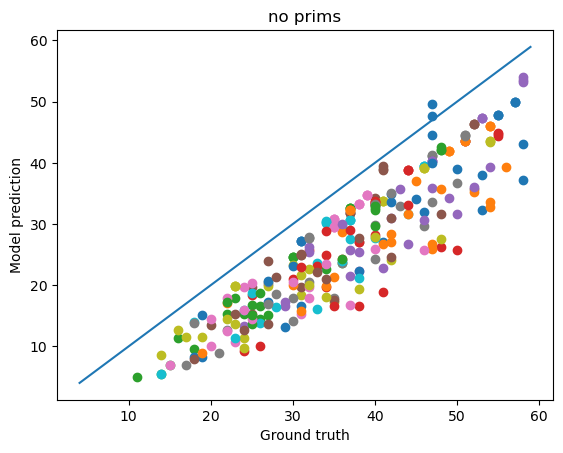

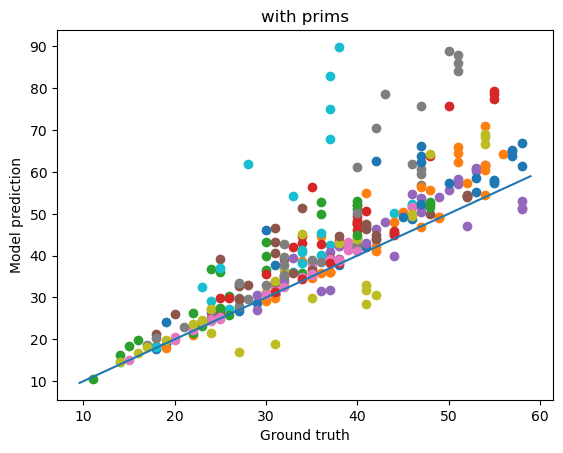

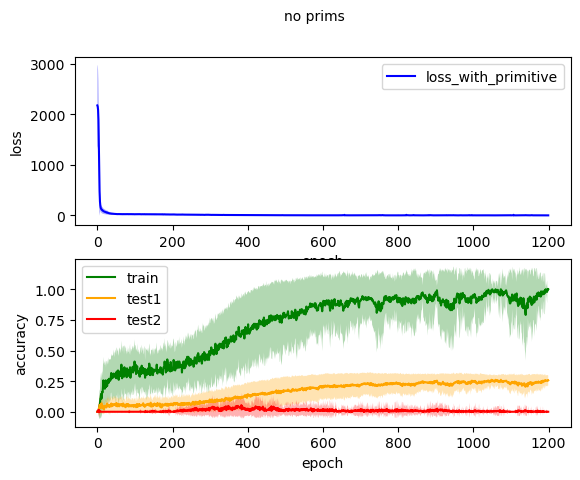

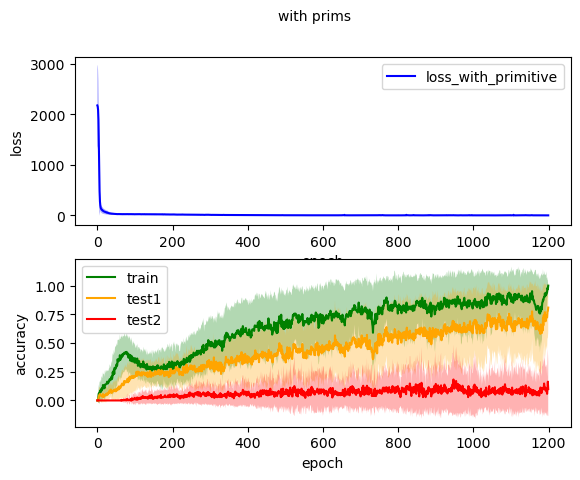

In [86]:
num_sims = 80
epochs = 1200

trainseqs = generate_pos_other(ops, all_syms, cue_dict) + generate_complex_primitives(ops, all_syms, cue_dict)
trainseqs_p = generate_pos_other(ops, all_syms, cue_dict) + pos_primitives
testseqs1 = generate_pos_trials(ops, all_syms, all_syms, cue_dict)
testseqs1 = [seq for seq in te stseqs1 if seq not in trainseqs]
testseqs2 = random.sample(generate_pos_trials(ops, all_syms, all_syms, cue_dict, steps = 3), 8)
print('train: ', trainseqs)
print('test 1: ', testseqs1)
print('test 2: ', testseqs2)

res2 = collect_accs(trainseqs, trainseqs_p, testseqs1, testseqs2, cue_dict, num_inputs)

# representations

no. 100% trained RNNs:  68


Text(0.5, 0.98, 'with primitives')

<Figure size 600x600 with 0 Axes>

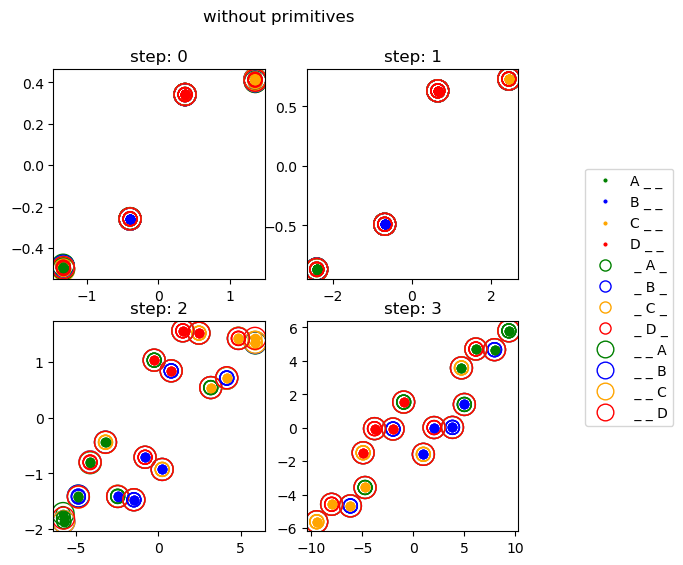

<Figure size 600x600 with 0 Axes>

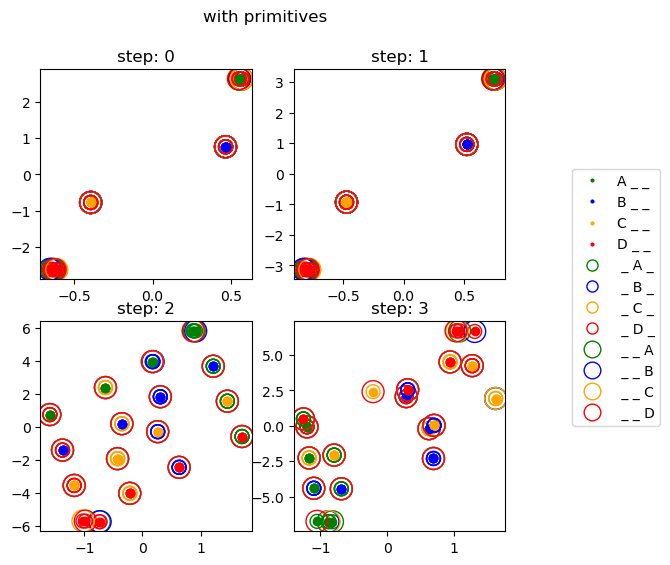

In [132]:
trainseq = generate_pos_other(ops, all_syms, cue_dict) + generate_complex_primitives(ops, all_syms, cue_dict)
testseq = generate_pos_trials(ops, all_syms, all_syms, cue_dict, steps = 2)
res_rdm = calculate_RDMs(res, testseq)

rdms = res_rdm['rdms']
rdms_p = res_rdm['rdms_p']
cue_dicts = res_rdm['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(5)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(5)]

plt.figure()
MDS_plot(matlist)
plt.suptitle('without primitives')
plt.figure()
MDS_plot(matlist_p)
plt.suptitle('with primitives')

In [135]:
from sklearn.decomposition import PCA
for i in range(1,len(matlist)):
    pca = PCA(n_components=3)
    pca_np = pca.fit(matlist[i])
    print('no prims: step',i,'  ', pca.explained_variance_ratio_)


no prims: step 1    [0.82661037 0.13836001 0.03502962]
no prims: step 2    [0.82385079 0.14112844 0.03502077]
no prims: step 3    [0.8075933  0.16303975 0.01455527]
no prims: step 4    [0.80573174 0.16492922 0.01464325]


In [137]:
from sklearn.decomposition import PCA
for i in range(1,len(matlist_p)):
    pca = PCA(n_components=3)
    pca_np = pca.fit(matlist_p[i])
    print('with prims: step',i,'  ', pca.explained_variance_ratio_)


with prims: step 1    [0.82050473 0.15234378 0.02715149]
with prims: step 2    [0.82764412 0.14735465 0.02500123]
with prims: step 3    [0.73241174 0.21764348 0.01472697]
with prims: step 4    [0.72498463 0.23881943 0.0100698 ]


In [ ]:
testseq = generate_pos_trials(ops, all_syms, all_syms, cue_dict, steps = 3)
res_rdm = calculate_RDMs(res2, testseq)

rdms = res_rdm['rdms']
rdms_p = res_rdm['rdms_p']
cue_dicts = res_rdm['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(5)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(5)]

plt.figure()
MDS_plot(matlist, train_type = 'n')
plt.suptitle('without primitives')
plt.figure()
MDS_plot(matlist_p, train_type = 'p')
plt.suptitle('with primitives')

In [107]:
def calculate_RDMs(res, testseq, fully_trained = True):
    
    acc_df = res['acc_df']
    if fully_trained:
        all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)].index
    else:
        all_acc_mods = acc_df.index
    print('no. 100% trained RNNs: ', len(all_acc_mods))
    mod_list = all_acc_mods # choose subset of rnns 
    
    rdms = [[] for _ in range(5)] # initialise empty lists/arrays
    rdms_p = [[] for _ in range(5)]

    # extracts results from dictionary
    mods = res['mods']
    mods_p = res['mods_p']
    cue_dicts = res['cue_dicts']
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        test_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(test_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(5): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(5):
            hid_vals = np.array([hid[h,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)
            
    return {'rdms': rdms, 'rdms_p': rdms_p, 'ft_cue_dicts': ft_cue_dicts}


In [100]:
res = calculate_RDMs(res)
rdms = res['rdms']
rdms_p = res['rdms_p']
cue_dicts = res['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
matlist_p = [np.array(rdms_p[t]).mean(axis=0) for t in range(4)]

KeyError: 'acc_df'

In [99]:
res.keys()

dict_keys(['rdms', 'rdms_p', 'ft_cue_dicts'])

In [88]:
testseqs=testseqs1

In [96]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy


## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 


## calculate distance matrices for all models and steps 

def calculate_RDMs(res):
    ## find indices of 100% acc rnns
    acc_df = res['acc_df']
    #all_acc_mods = acc_df.index
    all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)].index
    #all_acc_mods = acc_df[(acc_df['acc_train'] == 1) & (acc_df['acc_train_p'] == 1)& (acc_df['acc_train_rp'] == 1)].index
    print('no. 100% trained RNNs: ', len(all_acc_mods))

    mod_list = all_acc_mods # choose only rnns trained to 100%
    # mod_list = np.arange(num_sims)

    # initialise empty lists/arrays
    rdms = [[] for _ in range(4)]
    rdms_p = [[] for _ in range(4)]

    # extracts results from dictionary
    mods = res['mods']
    mods_p = res['mods_p']
    cue_dicts = res['cue_dicts']
    testseq = generate_trials(ops, all_syms, all_syms, cue_dict)
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
                    
        # get activations for primitive trained model
        hiddens_p, trials = get_reps(mods_p[m], [testset], hidden_size)    
        for h in range(4):
            hid_vals = np.array([hid[h,:] for hid in hiddens_p])
            rep_mat = euclidean_distances(hid_vals)
            rdms_p[h].append(rep_mat)
            
    return {'rdms': rdms, 'rdms_p': rdms_p, 'ft_cue_dicts': ft_cue_dicts}

# for ranked control
rank_dict = {'A': -1.5, 'B': -0.5, 'C': 0.5, 'D': 1.5}

# for selecting untrained trials
rp = generate_other(ops, all_syms, cue_dict) + generate_other_reverse_primitives('+', all_syms, cue_dict)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]

def regress_RDM_abs(time_step, rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        x = []
        y = []
        for p in valset_idx:
            for q in valset_idx:
                x.append(rdm[time_step][i][p,q])
                y.append(truth_RDM[p,q])
        x = np.array(x).reshape(-1,1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rs.append(r_sq)
    return rs

def truth_RDM_init(rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        init_tests = [[t[0]]+['='] for t in curr_tests ]
        truth_outs = [calculate_output(t, cuedict) for t in init_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        rs.append(truth_RDM)
    return rs

def truth_RDM(rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        rs.append(truth_RDM)
    return rs

